In this notebook we render, with the rasterizer provided by Pytorch 3D, a mesh extracted with Marching Tetrahedra from a pre-trained Radfoam.

In [1]:
import sys
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import configargparse
import os

sys.path.append('../')
from radfoam_model.mesh_utils import marching_tetrahedra
from radfoam_model.scene import RadFoamScene
from configs import ModelParams, DatasetParams, OptimizationParams

from data_loader.pycolmap.pycolmap.scene_manager import SceneManager
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, RasterizationSettings,
    SoftPhongShader,
    PointLights,
    PerspectiveCameras,
    TexturesVertex
)

In [2]:
device = 'cuda'
scene = "bonsai"
path_to_pretrained = f'../../radfoam_original/output/{scene}/model.pt'
path_to_data = '../../../data/mipnerf360/'
colmap_dir = os.path.join(path_to_data, scene, "sparse/0/")

In [3]:
# Parser to initialize model, camera parameters and stuff
parser = configargparse.ArgParser()
model_args = ModelParams(parser)
optimizer_args = OptimizationParams(parser)
dataset_args = DatasetParams(parser)

In [4]:
# We load the scene
model = RadFoamScene(args=model_args, device=device, attr_dtype=torch.float16)
model.load_pt(path_to_pretrained)
model.declare_optimizer(
        args=optimizer_args,
        warmup=1,
        max_iterations=2,
    )
model.update_triangulation()

# We obtain the colors
color_attributes = model.get_primal_attributes()

C0 = 0.28209479177387814
r = 0.5 + C0 * color_attributes[:, 0]
g = 0.5 + C0 * color_attributes[:, 1]
b = 0.5 + C0 * color_attributes[:, 2]

primal_features = torch.stack([r, g, b], axis=1).float()

In [5]:
from data_loader import DataHandler
dataset_args.scene = scene
dataset_args.data_path = path_to_data
test_data_handler = DataHandler(
        dataset_args, rays_per_batch=0, device=device
)
# Setting up cameras to send to CUDA
if scene in ["garden", "stump", "bicycle"]:
        downsample = 4
elif scene in ["room", "bonsai", "counter", "kitchen"]:
        downsample = 2
elif scene in ["playroom", "drjohnson"]:
        downsample = 1
else:
        raise ValueError("Unknown scene")

test_data_handler.reload(
        split="train", downsample=downsample
    )

Loading data (255): 100%|██████████| 255/255 [00:03<00:00, 70.96it/s]


In [6]:
def get_camera_parameters_from_data_handler(datahandler,idx):
    width, height = datahandler.img_wh
    c2w = datahandler.c2ws[idx].to(device)
    ground_truth_image = datahandler.train_rgbs.view(datahandler.c2ws.shape[0],height,width,3)[idx]
    K = datahandler.K.to(device)
    fx = K[0][0]
    fy = K[1][1]
    cx = K[0][2]
    cy = K[1][2]

    rotation = c2w[:3, :3]
    translation = c2w[:3, 3:]

    return ground_truth_image,rotation, translation, height, width, fx, fy, cx, cy

def get_camera_parameters(idx):
    '''
    Inputs the idx in the colmap dataset and outputs the corresponding camera parameters
    '''
    # Setting up cameras to send to CUDA
    if scene in ["garden", "stump", "bicycle"]:
        downsample = 4
    elif scene in ["room", "bonsai", "counter", "kitchen"]:
        downsample = 2
    elif scene in ["playroom", "drjohnson"]:
        downsample = 1
    else:
        raise ValueError("Unknown scene")

    manager = SceneManager(colmap_dir)
    manager.load_cameras()
    manager.load_images()

    cam = manager.cameras[1]
    fx, fy, cx, cy = cam.fx, cam.fy, cam.cx, cam.cy
    fx = fx / downsample
    fy = fy / downsample
    cx = cx / downsample
    cy = cy / downsample

    imdata = manager.images
    w2c_mats = []
    bottom = np.array([0, 0, 0, 1]).reshape(1, 4)
    for k in imdata:
        im = imdata[k]
        rot = im.R()
        trans = im.tvec.reshape(3, 1)
        w2c = np.concatenate([np.concatenate([rot, trans], 1), bottom], axis=0)
        w2c_mats.append(w2c)

    w2c_mats = np.stack(w2c_mats, axis=0)

    c2w_mats = np.linalg.inv(w2c_mats)

    image_names = [imdata[k].name for k in imdata]
    inds = np.argsort(image_names)
    c2w_mats = c2w_mats[inds]
    c2w = torch.tensor(c2w_mats[idx], dtype=torch.float32).to(device)

    image_names = [imdata[k].name for k in imdata]
    # Camera parameters
    if downsample > 1:
        img_path = os.path.join(
            path_to_data,
            scene,
            f"images_{downsample}",
            image_names[idx],
        )
    else:
        img_path = os.path.join(
            path_to_data, scene, "images", image_names[idx]
        )
        
    img_0 = Image.open(img_path)
    height, width = img_0.size[1], img_0.size[0]

    rotation = c2w[:3, :3]
    translation = c2w[:3, 3:]

    return img_0,rotation, translation, height, width, fx, fy, cx, cy

def colmap_to_pytorch3d(rotation,translation):
    '''
    Changes the rotation and translation from the colmap to the pytorch 3D convention.
    '''
    rotation = torch.stack([-rotation[:, 0], -rotation[:, 1], rotation[:, 2]], 1) # from RDF to Left-Up-Forward for Rotation
    new_c2w = torch.cat([rotation, translation], 1)
    bottom = torch.Tensor([[0,0,0,1]]).to(device)
    w2c = torch.linalg.inv(torch.cat((new_c2w, bottom), 0))
    rotation, translation = w2c[:3, :3].permute(1, 0), w2c[:3, 3]

    return rotation, translation

def render_mesh(v,f,feat,idx=0):
    '''
    Render the mesh given extracted vertices v and faces f. 
    This function outputs an image
    '''
    # Loading the mesh
    verts = v.unsqueeze(0)
    faces = f.unsqueeze(0).to(device)
    features = feat.unsqueeze(0)

    textures = TexturesVertex(verts_features=features)
    mesh = Meshes(verts=verts, faces=faces, textures=textures)

    # Get the camera parameters
    # ground_truth_image, rotation, translation, height, width, fx, fy, cx, cy = get_camera_parameters(idx)
    ground_truth_image, rotation, translation, height, width, fx, fy, cx, cy = get_camera_parameters_from_data_handler(test_data_handler,idx)
    rotation, translation = colmap_to_pytorch3d(rotation,translation)

    cameras = PerspectiveCameras(device=device, 
                                 R=rotation.unsqueeze(0).to(device), 
                                 T=translation.unsqueeze(0).to(device),
                                 in_ndc=False,
                                 image_size=((height,width),),
                                 focal_length=((fx,fy),),
                                 principal_point=((cx,cy),))
    
    lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]],ambient_color=((1.0,1.0,1.0),))

    # Rasterization settings
    raster_settings = RasterizationSettings(
        image_size=(height,width),
        blur_radius=0.0,
        faces_per_pixel=1
    )

    # Define rasterizer
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

    # Define shader (Phong shading)
    shader = SoftPhongShader(device=device, cameras=cameras, lights=lights)

    # Create the MeshRenderer
    renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

    # Render the image
    return ground_truth_image,renderer(mesh)

In [7]:
# Generate mesh and plot
primal_values = (model.get_primal_density().squeeze() - 5)

v, f, feat = marching_tetrahedra(model.triangulation.tets().long(), 
                                 primal_values, 
                                 model.primal_points, 
                                 primal_features)

# We generate a random image every time we run this cell.
ground_truth_image, image = render_mesh(v,f,feat,idx=np.random.randint(0,161))

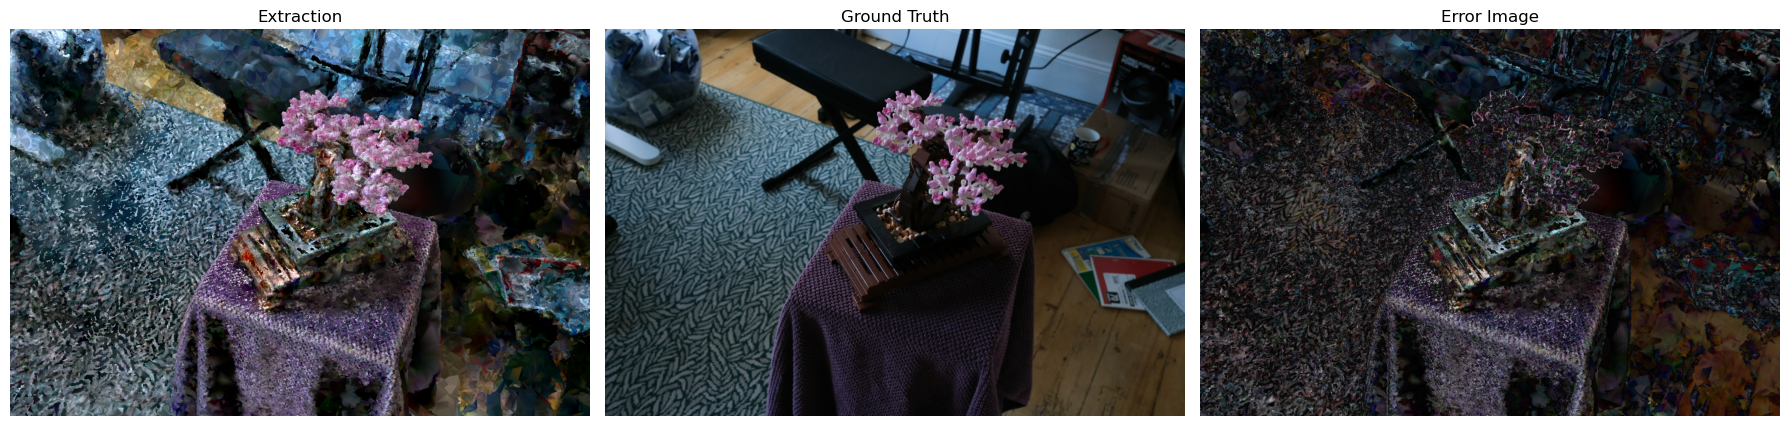

In [8]:
# Convert prediction image from RGBA to RGB
pred_rgb = image[..., :3].cpu().detach().squeeze(0).numpy()
pred_rgb = pred_rgb.clip(0, 1)  # Ensure valid range

# Ensure ground truth image is also in valid range
if ground_truth_image is None:
    ground_truth_image = np.zeros_like(pred_rgb)
elif isinstance(ground_truth_image,torch.Tensor):
    gt_rgb = ground_truth_image.numpy()
else:
    gt_rgb = np.array(ground_truth_image, dtype=np.float32) / 255.0  # Convert to [0,1] range

if gt_rgb.shape[:2] != pred_rgb.shape[:2]:
    gt_rgb = np.array(Image.fromarray((gt_rgb * 255).astype(np.uint8)).resize(pred_rgb.shape[1::-1])) / 255.0

# Compute the error image (absolute difference)
error_image = np.abs(pred_rgb - gt_rgb)
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot predicted image
axes[0].imshow(pred_rgb)
axes[0].set_title("Extraction")
axes[0].axis("off")

# Plot ground truth image
axes[1].imshow(gt_rgb)
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Plot error image
axes[2].imshow(error_image)
axes[2].set_title("Error Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [10]:
image.shape

torch.Size([1, 1039, 1559, 4])